[How-to Build a Transformer for Language Classification in TensorFlow
](https://https://www.youtube.com/watch?v=GYDFBfx8Ts8&t=218s)

In [1]:
!pip install kaggle

[How to Load Kaggle Datasets Directly into Google Colab?](https://https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

[Easy way to use Kaggle datasets in Google Colab](https://https://www.kaggle.com/general/51898)

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/ # Copy the “kaggle.json” into this new directory

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
import kaggle

In [7]:
api = KaggleApi()
api.authenticate()

In [8]:
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'train.tsv.zip', path='./')

100%|██████████| 1.28M/1.28M [00:00<00:00, 120MB/s]

In [9]:
import zipfile
with zipfile.ZipFile('train.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

In [10]:
import pandas as pd
df = pd.read_csv('train.tsv', sep='\t')

In [11]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [12]:
df.drop_duplicates(subset='SentenceId', keep='first', inplace=True)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [13]:
len(df)

8529

In [14]:
suqlen = df['Phrase'].apply(lambda x: len(x.split()))

In [15]:
suqlen

0         37
63        11
81        21
116       26
156        7
          ..
155984    16
155997    26
156021    17
156031    11
156039    21
Name: Phrase, Length: 8529, dtype: int64

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt 

<Figure size 1152x720 with 0 Axes>

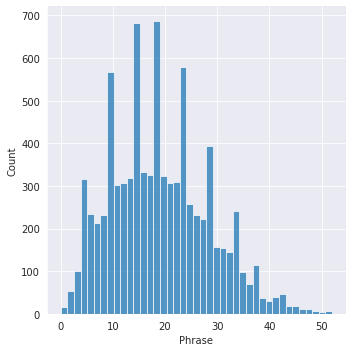

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 10))
sns.displot(suqlen)

In [18]:
SEQ_LEN = 50

In [19]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 4.9 MB/s 
     |████████████████████████████████| 895 kB 57.0 MB/s 
     |████████████████████████████████| 3.3 MB 22.4 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 596 kB 69.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [20]:
from transformers import AutoTokenizer

In [21]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [22]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [23]:
tokens = tokenizer.encode_plus("hello word", max_length=SEQ_LEN, truncation=True,
                               padding="max_length", add_special_tokens=True,
                               return_token_type_ids=False, return_attention_mask=True,
                               return_tensors='tf')

In [24]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[  101, 19082,  1937,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [25]:
import numpy as np 

In [26]:
Xids = np.zeros((len(df), SEQ_LEN))
Xmask = np.zeros((len(df), SEQ_LEN))

In [27]:
Xids.shape

(8529, 50)

In [28]:
for i, sequence in enumerate(df['Phrase']):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, truncation=True,
                               padding="max_length", add_special_tokens=True,
                               return_token_type_ids=False, return_attention_mask=True,
                               return_tensors='tf')
    Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

In [29]:
Xids
# 101: start of seq token, 102: end of seq token (padding tokens)

array([[ 101.,  138., 1326., ...,    0.,    0.,    0.],
       [ 101., 1188., 3589., ...,    0.,    0.,    0.],
       [ 101., 2431., 3899., ...,    0.,    0.,    0.],
       ...,
       [ 101.,  118.,  149., ...,    0.,    0.,    0.],
       [ 101., 1109., 2523., ...,    0.,    0.,    0.],
       [ 101., 1109., 1273., ...,    0.,    0.,    0.]])

In [30]:
Xmask
# our attention mask, we have the ones (1) to pay attention to and
# the zeros ignore 

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Now lets one hot encode our labels

In [31]:
df['Sentiment'].unique

<bound method Series.unique of 0         1
63        4
81        1
116       3
156       1
         ..
155984    2
155997    2
156021    1
156031    1
156039    2
Name: Sentiment, Length: 8529, dtype: int64>

In [32]:
# create an array from the dataframe column
arr = df['Sentiment'].values
arr.size

8529

In [33]:
labels = np.zeros((arr.size, arr.max() + 1))

In [34]:
labels.shape

(8529, 5)

In [35]:
labels[np.arange(arr.size), arr] = 1

In [36]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [37]:
# we save them
with open('xids.npy', 'wb') as f:
    np.save(f, Xids)
with open('xmask.npy', 'wb') as f:
    np.save(f, Xmask)
with open('labels.npy', 'wb') as f:
    np.save(f, labels)



In [38]:
# we load them
with open('xids.npy', 'rb') as fp:
    Xids = np.load(fp)
with open('xmask.npy', 'rb') as fp:
    Xmask = np.load(fp)
with open('labels.npy', 'rb') as fp:
    labels = np.load(fp)

In [39]:
Xids

array([[ 101.,  138., 1326., ...,    0.,    0.,    0.],
       [ 101., 1188., 3589., ...,    0.,    0.,    0.],
       [ 101., 2431., 3899., ...,    0.,    0.,    0.],
       ...,
       [ 101.,  118.,  149., ...,    0.,    0.,    0.],
       [ 101., 1109., 2523., ...,    0.,    0.,    0.],
       [ 101., 1109., 1273., ...,    0.,    0.,    0.]])

Now, we need to put all of our arrays into a tensorflow dataset object. Tf makes things a lot easier so we can restructer, shuffle and batch the data in just a few lines of code which is a lot faster and simpler.

In [40]:
import tensorflow as tf

In [41]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [42]:
# lets see our dataset
for i in dataset.take(1): 
    print(i)


(<tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,   138.,  1326.,  1104., 13936., 25265., 16913., 15107.,
        1103.,  8050.,  2553.,  1115.,  1184.,  1110.,  1363.,  1111.,
        1103., 20398.,  1110.,  1145.,  1363.,  1111.,  1103.,   176.,
        9900.,   117.,  1199.,  1104.,  1134.,  5411.,  1821., 14225.,
        1133.,  3839.,  1104.,  1134.,  7919.,  1106.,  1277.,  1104.,
         170.,  1642.,   119.,   102.,     0.,     0.,     0.,     0.,
           0.,     0.])>, <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>, <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0., 1., 0., 0., 0.])>)


In [43]:
# we have a dict so:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [44]:
dataset = dataset.map(map_func)

In [45]:
for i in dataset.take(1): 
    print(i)

({'input_ids': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,   138.,  1326.,  1104., 13936., 25265., 16913., 15107.,
        1103.,  8050.,  2553.,  1115.,  1184.,  1110.,  1363.,  1111.,
        1103., 20398.,  1110.,  1145.,  1363.,  1111.,  1103.,   176.,
        9900.,   117.,  1199.,  1104.,  1134.,  5411.,  1821., 14225.,
        1133.,  3839.,  1104.,  1134.,  7919.,  1106.,  1277.,  1104.,
         170.,  1642.,   119.,   102.,     0.,     0.,     0.,     0.,
           0.,     0.])>, 'attention_mask': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>}, <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0., 1., 0., 0., 0.])>)


In [46]:
# shuffle
dataset = dataset.shuffle(100000).batch(32)

In [47]:
# split train and validation
DS_LEN = len(list(dataset))


In [48]:
DS_LEN

267

In [49]:
SPLIT = 0.9
train = dataset.take(round(DS_LEN*SPLIT))
val = dataset.skip(round(DS_LEN*SPLIT))

Now data is ready, we can build our model architecture

In [50]:
# first we initialize bert 
from transformers import TFAutoModel

In [51]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [52]:
# define our input layers, we have 2: ids and masks
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32') # same names as we have in the tensor

# now we need to pull the embeddings from our initialized bert model
embeddings = bert(input_ids, attention_mask=mask)[0]

x = tf.keras.layers.GlobalMaxPooling1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

Bert is very big model and we wouldn't train it unless we have a specific reason to. For this dataset , we are going to freeze some layers 

In [54]:
model.layers[2].trainable = False

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

In [56]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [57]:
history = model.fit(train, validation_data=val, epochs=140)

Epoch 1/140
240/240 [==============================] - 44s 136ms/step - loss: 1.4706 - accuracy: 0.3603 - val_loss: 1.3168 - val_accuracy: 0.4417
Epoch 2/140
240/240 [==============================] - 30s 126ms/step - loss: 1.3639 - accuracy: 0.4072 - val_loss: 1.2300 - val_accuracy: 0.4912
Epoch 3/140
240/240 [==============================] - 31s 128ms/step - loss: 1.3292 - accuracy: 0.4130 - val_loss: 1.2137 - val_accuracy: 0.4676
Epoch 4/140
240/240 [==============================] - 31s 130ms/step - loss: 1.3184 - accuracy: 0.4225 - val_loss: 1.2449 - val_accuracy: 0.4558
Epoch 5/140
240/240 [==============================] - 32s 131ms/step - loss: 1.3032 - accuracy: 0.4288 - val_loss: 1.2147 - val_accuracy: 0.4794
Epoch 6/140
240/240 [==============================] - 32s 131ms/step - loss: 1.2991 - accuracy: 0.4350 - val_loss: 1.1843 - val_accuracy: 0.4817
Epoch 7/140
240/240 [==============================] - 32s 131ms/step - loss: 1.2898 - accuracy: 0.4402 - val_loss: 1.1820 -